# Successor representations and state aggregation in reinforcement learning
### Jake Russin
### 12/15/17

### Imports:

In [1055]:
import numpy as np
from scipy import ndimage
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import manifold
from scipy import stats
from sklearn.metrics import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
%matplotlib inline

## Introduction

For this project I tested the following three reinforcement learning algorithms on different environments:
1. Simple TD-learning on state space
2. TD-learning of successor representations, which are the expected temporally discounted number of times the agent will occupy each state in the future, given that it is in a certain state
3. TD-learning on clustered state space, where clusters are determined by Bayesian Gaussian mixture modeling on the successor representations learned on a random walk of the environment

The environemnts were constructed from the python library 'networkx', which allows for easy construction of graphs. The transition matrices I used were deterministic, where the agent could choose any node in the graph that was connected to its current node. The reward structure was simple: one node in the graph served as the goal and had a reward value of 1, while the rest of the nodes had a value of -0.01. On each trial the agent started in a random state, and had to learn to make its way to the goal node.

Comparisons were made between algorithms by implementing the same epsilon-greedy response rule in each, and setting all other common parameters equal.

Here's a simple example of one of the environments:

In [2882]:
nrooms = 5
roomsize = 8
rooms = nx.Graph()
for r in range(nrooms):
    Gnodes = range(r*roomsize,r*roomsize + roomsize)
    Gedges = itertools.combinations(Gnodes,2)
    G = nx.Graph()
    G.add_nodes_from(Gnodes)
    G.add_edges_from(Gedges)
    rooms = nx.compose(rooms,G)
    if r > 0:
        rooms.add_edge(r*roomsize-1,r*roomsize)
rooms.add_edge(nrooms*roomsize-1,0)

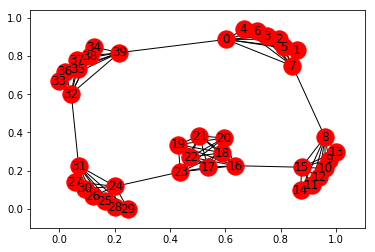

In [3546]:
nx.draw_networkx(rooms)
plt.show()

(In this plot and in all similar plots hereafter, the graphs are drawn with a method from networkx. I don't know exaclty how it decides how to draw the graphs (i.e. how long each edge should be and so on), but I only use the plots to get a general sense of how the environments look. Also, the networkx method has some randomness in it, so often the same environment will look slightly different from drawing to drawing.)

## TD learning

Here I've just implemented the basic TD-learning algorithm for learning the expected temporally discounted future reward for each state.

Model: ("R" rather than "V" in code)
$$ V \in R^n $$

Definition:
$$ V(s^i) = E[\sum_{n=0}^{\infty} \gamma^n R(s_n)| s_0 = s^i]$$

Update equation in state $s^i$:
$$ V_{n+1}(s^i) = V_{n}(s^i) + \eta[R(s^i) + \gamma V(s_{n+1}) - V_{n}(s^i)] $$

As noted above, a stationary epsilon-greedy response rule was used throughout the testing. However, I also implemented a discounting factor for epsilon (which was set to 1 for all training and testing), and a softmax option, along with a temperature parameter and a temperature-discounting factor for simulalted annealing. The learning rates and temporal discount parameters were not chosen too carefully - I just found a couple that worked and stuck with those.

In [2724]:
class TD_rl:
    def __init__(self,world,rg=0.9,re=0.01,epsilon=0.3,gg=1,T=1,Tg=0.99,trial_structure=1,softmax=True):
        self.world = world #learning environment
        #Hyperparameters
        self.rg = rg #temporal discounting parameter for reward vector
        self.re= re#learning rate for reward model
        self.epsilon = epsilon #epsilon-greedy parameter (probability of random action)
        self.gg = gg #epsilon-greedy discount factor
        self.T=T #initial temperature
        self.Tg=Tg #temperature discount factor for simulated annealing
        self.trial_structure = trial_structure #Random state vs. random action chosen after goal is reached
        self.softmax = softmax #Softmax for response rule
        self.nnodes = world.number_of_nodes()
    
        #Model
        self.R = np.zeros(self.nnodes) #Reward model
    
    def train(self,goal,ntrials):
        state = np.random.choice(self.world.nodes()) #Random starting point
        count = 0 #Count for the number of steps it takes to reach the goal
        stepcounts = [] #Record number of steps taken on each trial
        temp = self.T
        eps = self.epsilon
        for i in range(ntrials):
            if self.trial_structure:
                state = np.random.choice(self.world.nodes()) #Random starting point
            count = 0 #Start count over
            done = False
            while not done:
                done = (state == goal) or (count > 100)
                actions = self.world.neighbors(state) #Available next states
                greedy = np.random.rand() > eps #Decide if greedy action taken (softmax-greedy)
                if greedy:
                    if self.softmax:
                        next_state = np.random.choice(actions,p=np.exp(self.R[actions]/temp)/np.sum(np.exp(self.R[actions]/temp))) #softmax
                    else:
                        max_reward = np.max(self.R[actions]) #maximum reward of available actions
                        next_state = np.random.choice(np.array(actions)[(self.R[actions] == max_reward)]) #Choose randomly between actions with maximum reward
                else:
                    next_state = np.random.choice(actions)
                next_actions = self.world.neighbors(next_state)
                reward = 1 if (next_state == goal) or (state==goal) else -0.01 #reward for the next state
                best_action = next_actions[np.argmax(self.R[next_actions])]
                #Update R
                self.R[state] = self.R[state] + self.re*(reward + self.rg*self.R[best_action] - self.R[state])
                #Update state
                state = next_state
                count += 1
                eps = eps*self.gg
            stepcounts.append(count)
            if temp > 0.1:
                temp = temp*self.Tg #Update temperature for simulated annealing
        return stepcounts
                
    def test(self,goal,ntest):
        count = 0 #Count for the number of steps it takes to reach the goal
        extrasteps = [] #Record number of steps taken on each trial

        for i in range(ntest):
            state = np.random.choice(self.world.nodes()) #Random starting point
            minsteps = nx.shortest_path_length(self.world,source=state,target=goal) #Compute shortest possible path
            count = 0 #Start count over
            while (state != goal) and (count < 100):
                actions = self.world.neighbors(state) #Available next states
                max_reward = np.max(self.R[actions]) #maximum reward of available actions
                state = np.random.choice(np.array(actions)[(self.R[actions] == max_reward)]) #Choose randomly between actions with maximum reward
                count += 1
            extrasteps.append(count-minsteps)
        return extrasteps

## Successor representation learning

A successor representation is the expected temporally-discounted number of times a state will be visited in the future, given the current state (Dayan, 1993, White, 1993). Successor representations are "temporally abstract": they are abstract representations of what the future looks like given that the agent is in the current state. SR-learning can therefore be thought of as somewhere in-between model-free and model-based reinforcement learning: whereas a model-free agent knows nothing about what states are likely to follow what other states and a model-based agent can deduce what other states are likely to follow what other states by tree-search on its learned transition matrix, SR-learning is somewhere in-between - it knows something of what the future looks like in a given state, but it does not compute this by an expensive tree-search algorithm (Botvinick, Niv, Barto, 2008). (Reference for equations: Gershman, Moore, Todd, Norman, & Sederberg, 2012)

Model:

Reward model ('R' in code): $$ \quad V \in R^n $$

Successor representation matrix, where row vectors are successor representations for each state: 

$$ \quad M \in R^{nxn} $$


Definition:
$$ M(s^i,s^j) = E[\sum_{n=0}^{\infty} \gamma^n I(s_{n} = s^j)| s_0 = s^i]$$,

where $I(s_{n} = s^j)$ is an indicator function for whether state $s_n = s^j$ 



Update equation in state $s^i$:
$$ M_{n+1}(s^i,s^j) = M_{n}(s^i,s^j) + \eta[I(s_{n+1} = s^j) + \gamma M_{n}(s_{n+1},s^j) - M_{n}(s^i,s^j)]e_{n}(s^i) $$,

where $e_{n}(s^i)$ is a leaky integrator:

$$ e_{n}(s^i) = 
\begin{cases}
\gamma \lambda e_{n-1}(s^i) \qquad \ \ if \ s^i \ne s_n \\
\gamma \lambda e_{n-1}(s^i) + 1 \quad if \ s^i = s_n
\end{cases}$$

The leaky integrator weights the learning of the successor representations by how recently states have been visited, so that the successor representation of the current state learns more about the states that have been visited more recently. $\lambda$ is a hyperparameter that controls the 'leakiness' of the integrator, i.e. how rapidly the weight of a state decays over time if it is not revisited.

The following code implements a class for successor representation learning. It contains all of the hyperparameters from the TD_rl class, plus those necessary for TD-learning of the successor representation matrix: a temporal discounting factor for the successor representations and a learning rate for the successor representations. It also contains an option for learning the successor representations on or off-policy, where off-policy learning means that the representations will reflect a random walk on the graph rather than the true successor representations for the responding agent. 

In [2723]:
class SR_rl:
    def __init__(self,world, rg=0.8,re=0.01,sg=0.6,se=0.1,gg=1,epsilon = 0.1,T=3,Tg=0.9999,l=0.7,trial_structure=1,softmax=True,M_offpolicy = False):
        self.world = world #learning environment
        #Hyperparameters
        self.rg = rg #temporal discounting parameter for reward learning
        self.re= re #learning rate for reward model
        self.sg = sg #temporal discounting parameter for SR learning
        self.se = se #learning rate for successor representation matrix
        self.epsilon = epsilon #epsilon-greedy parameter (probability of random action)
        self.gg = gg #epsilon-greedy discount factor
        self.T=T #initial temperature
        self.Tg=Tg #temperature discount factor for simulated annealing
        self.l = l #leaky integrator parameter
        self.trial_structure = trial_structure #Random state vs. random action chosen after goal is reached
        self.softmax = softmax #Softmax for response rule
        self.M_offpolicy = M_offpolicy
        self.nnodes = world.number_of_nodes()
    
        #Model
        self.R = np.zeros(self.nnodes) #Reward model
        self.M = np.zeros((self.nnodes,self.nnodes)) #SR matrix
    
    def train(self,goal,ntrials):
        state = np.random.choice(self.world.nodes()) #Random starting point
        temp = self.T
        eps = self.epsilon
        count = 0 #Count for the number of steps it takes to reach the goal
        stepcounts = [] #Record number of steps taken on each trial
        for i in range(ntrials):
            if self.trial_structure:
                state = np.random.choice(self.world.nodes()) #Random starting point
            count = 0 #Start count over
            done = False
            E = np.transpose(np.zeros(self.nnodes)) #leaky integrator for short-term memory
            while not done:
                done = (state == goal) or (count > 100)
                actions = self.world.neighbors(state) #Available next states
                MR = self.M.dot(self.R)
                greedy = np.random.rand() > self.epsilon #Decide if greedy action taken (softmax-greedy)
                if greedy:
                    if self.softmax:
                        next_state = np.random.choice(actions,p=np.exp(self.R[actions]/temp)/np.sum(np.exp(self.R[actions]/temp))) #softmax
                    else:
                        max_reward = np.max(self.R[actions]) #maximum reward of available actions
                        next_state = np.random.choice(np.array(actions)[(self.R[actions] == max_reward)]) #Choose randomly between actions with maximum reward
                else:
                    next_state = np.random.choice(actions)
                if done and self.trial_structure:
                    next_state = state
                next_actions = self.world.neighbors(next_state)
                reward = 1 if (next_state == goal) or (state==goal) else -0.01 #reward for the next state
                best_action = next_actions[np.argmax(self.R[next_actions])]
                #Update E
                E = self.l*self.sg*E + (np.arange(self.nnodes)==next_state) + 0.3
                #Update M
                if self.M_offpolicy:
                    if not done: #Need to differentiate done vs. not or else SR[7,7] will be lower than other SR[7_neighbors,7]
                        self.M[state,:] = self.M[state,:] + self.se*((0.25*np.array([i in actions for i in np.arange(self.nnodes)]) + self.sg*np.mean(self.M[actions,:],0) - self.M[state,:]))
                    else:
                        self.M[state,:] = self.M[state,:] + self.se*((np.arange(self.nnodes) == next_state) + self.sg*np.mean(self.M[actions,:],0) - self.M[state,:])
                else:
                    self.M[state,:] = self.M[state,:] + self.se*(((np.arange(self.nnodes) == next_state) + self.sg*self.M[next_state,:] - self.M[state,:])*E)
                #Update R
                self.R[state] = self.R[state] + self.re*(reward + self.rg*self.R[best_action] - self.R[state])
                #Update state
                state = next_state
                count += 1
                eps = eps*self.gg
            stepcounts.append(count)
            if temp > 0.1:
                temp = temp*self.Tg #Update temperature for simulated annealing
        return stepcounts
    def test(self,goal,ntest):
        extrasteps = [] #Record number of steps taken on each trial

        for i in range(ntest):
            state = np.random.choice(self.world.nodes()) #Random starting point
            minsteps = nx.shortest_path_length(self.world,source=state,target=goal) #Compute shortest possible path
            count = 0 #Start count over
            while (state != goal) and (count < 100):
                actions = self.world.neighbors(state) #Available next states
                max_reward = np.max(self.R[actions]) #maximum reward of available actions
                state = np.random.choice(np.array(actions)[(self.R[actions] == max_reward)]) #Choose randomly between actions with maximum reward
                count += 1
            extrasteps.append(count-minsteps)
        return extrasteps

### Visualizing successor representations

To get a better sense of successor representations, let's take a look at the rooms environment where the goal is node 5:

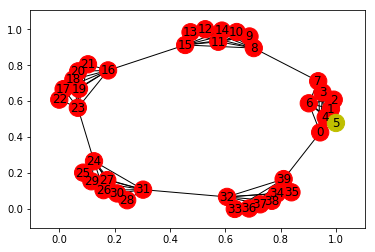

In [3573]:
goal = 5
node_colors = ['y' if i == goal else 'r' for i in range(rooms.number_of_nodes())]
nx.draw_networkx(rooms,node_color=node_colors)

#### Successor representations on an epsilon-greedy responding agent:

The following code trains an epsilon-greedy SR agent, and learns the successor representations on-policy, i.e. according to what the agent will actually do (as opposed to "off-policy" where the successor representations will reflect an agent on a random walk).

In [3364]:
ntrials = 1000
sr_rooms_eps = SR_rl(rooms,softmax=False,M_offpolicy=False,se=0.001,sg=0.99,l=0.9,epsilon=0.1,trial_structure=True)
sr_rooms_eps_sc = sr_rooms_eps.train(goal,ntrials)

The plots below show the successor representations learned by this agent on the original state-space of the graph. Each plot shows the successor representation for one state, i.e. one row of the SR matrix M: the colors indicate (on a logarithmic scale) the value of the SR matrix for each state, given the current state. So the first plot is the SR vector for state 0. From this plot, you can see that the agent expects to visit the goal-state 5 the most times in the temporally-discounted future.

One can see from these plots that in general the successor representations reflect the likely path of the agent toward the goal. If the agent is in the room with the goal, it is likely to go directly to it and stay there, and if the agent is in a different room, it will use the 'doors' that lead to the room where the goal is located. Every 4th state's SR is plotted.

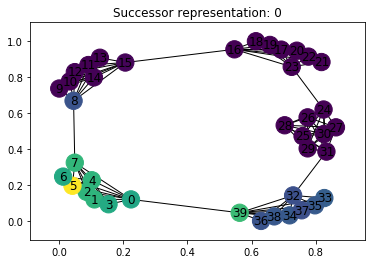

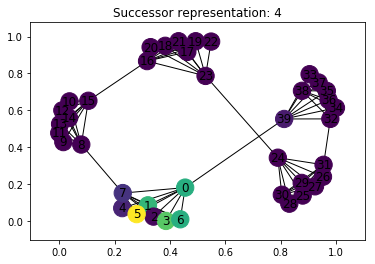

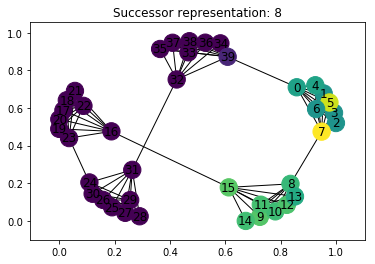

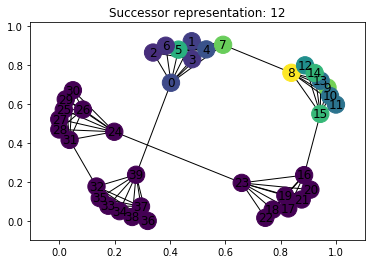

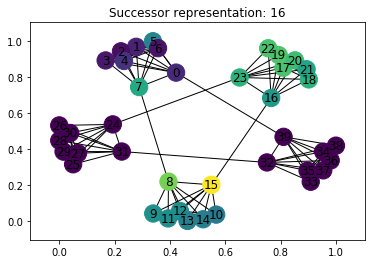

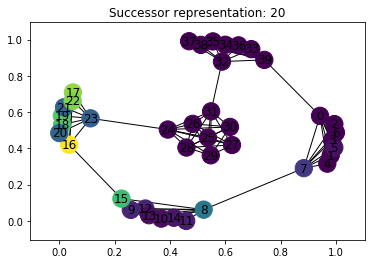

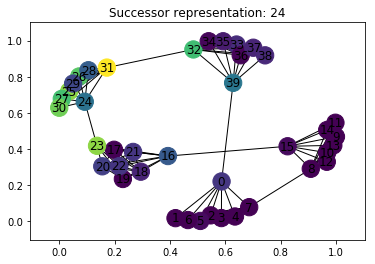

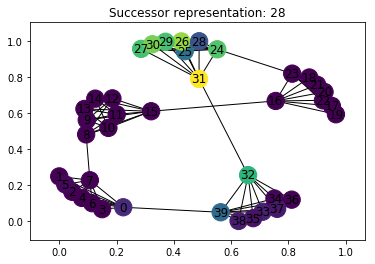

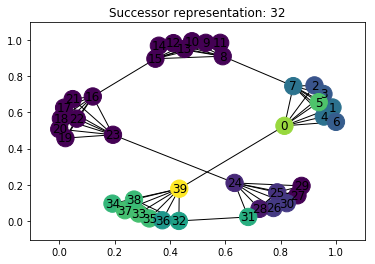

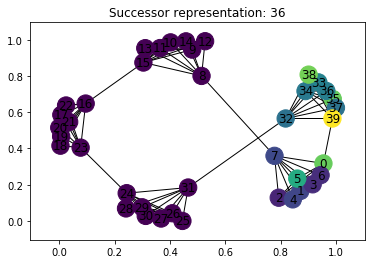

In [3366]:
# Plot successor representations for each state on state spacce
for i in 4*np.arange(rooms.number_of_nodes()/4):
    plt.clf()
    node_colors = np.log(sr_rooms_eps.M[i,:]+0.000001)
    nx.draw_networkx(rooms,node_color=node_colors)
    plt.title('Successor representation: %d' % i)
    plt.show()

#### Multidimensional scaling on successor representations for epsilon-greedy responding agent

The code below performs multidimensional scaling on the successor representations learned by an epsilon-greedy responding agent.

In [3367]:
similarities_sr_rooms_eps = euclidean_distances(sr_rooms_eps.M)
mds_sr_rooms_eps = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
fit_sr_rooms_eps = mds.fit(similarities_sr_rooms_eps).embedding_

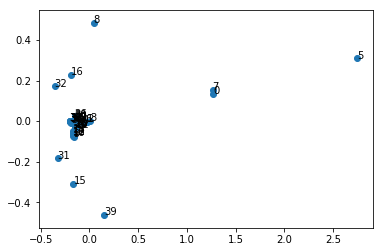

In [3368]:
fig, ax = plt.subplots()
ax.scatter(fit_sr_rooms_eps[:,0],fit_sr_rooms_eps[:,1])
for i, txt in enumerate(range(rooms.number_of_nodes())):
    ax.annotate(txt, (fit_sr_rooms_eps[i,0],fit_sr_rooms_eps[i,1]))
plt.show()

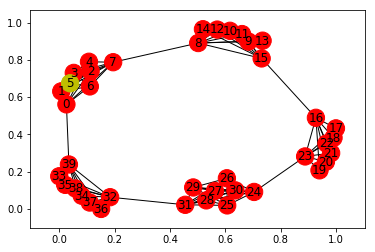

In [3345]:
node_colors = ['y' if i == goal else 'r' for i in range(rooms.number_of_nodes())]
nx.draw_networkx(rooms,node_color=node_colors)

In the MDS plot, we can see that states cluster together according to their relationship with the goal: 
- The goal node (5) lies all alone because its successor representation will reflect the fact that the agent will just stay put once the goal is reached
- Nodes 0 and 7 are the "doors" to the room where the goal is found, and they are seen between the other rooms and the goal node (although this is not necessarily reflected after doing MDS to restrict to 2 dimensions).
- The nodes in each main room are clustered together, with the other door nodes generally have their own special successor representations outside of the main clusters

#### Successor representations on a random walk

The following code learns the successor representations on a random walk on this graph:

In [2917]:
ntrials = 10000
sr_rooms_random = SR_rl(rooms,softmax=False,M_offpolicy=False,se=0.0001,sg=0.9999,l=0.95,epsilon=1,trial_structure=False)
sr_rooms_random_sc = sr_rooms_random.train(goal,ntrials)

Here's the reward model learned by the agent:

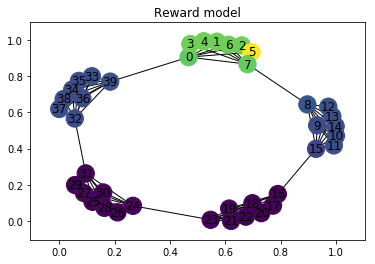

In [2929]:
# Plot reward on state space
node_colors = sr_rooms_random.R
nx.draw_networkx(rooms,node_color=node_colors)
plt.title('Reward model')
plt.show()

And here are some of the successor representations learned by the agent, where again the coloring indicates the magnitude of the SR. From these we can see that each state's SR looks approximately the same, depending on which room it is in, and whether it is a door or not.

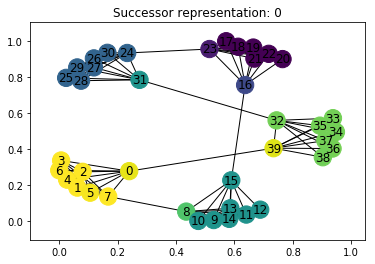

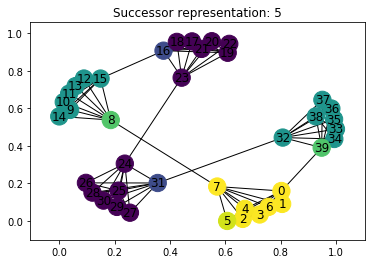

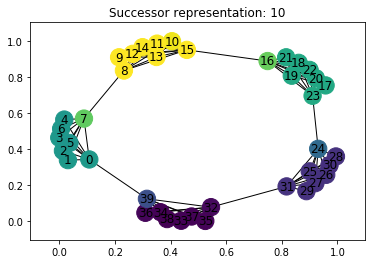

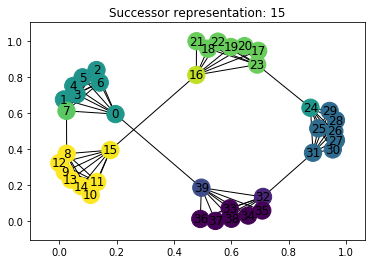

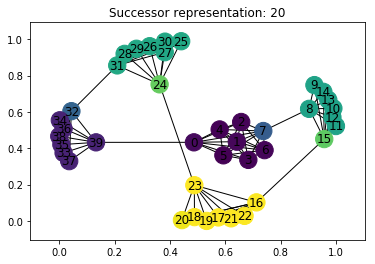

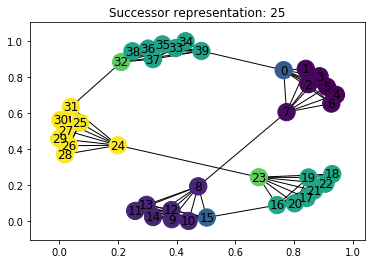

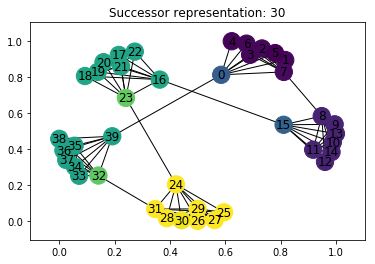

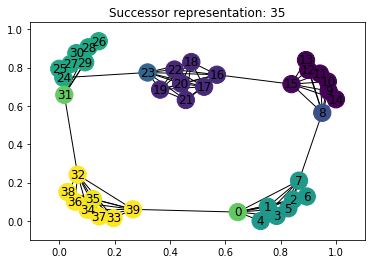

In [3574]:
# Plot successor representations for each state on state spacce
for i in 5*np.arange(rooms.number_of_nodes()/5):
    plt.clf()
    node_colors = np.log(sr_rooms_random.M[i,:])
    nx.draw_networkx(rooms,node_color=node_colors)
    plt.title('Successor representation: %d' % i)
    plt.show()

#### Multidimensional scaling on successor representations for random-walk agent

In [2930]:
similarities = euclidean_distances(sr_rooms_random.M)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
fit = mds.fit(similarities).embedding_

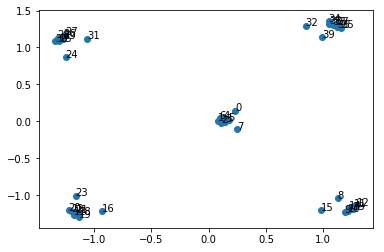

In [2931]:
fig, ax = plt.subplots()
ax.scatter(fit[:,0],fit[:,1])
for i, txt in enumerate(range(rooms.number_of_nodes())):
    ax.annotate(txt, (fit[i,0],fit[i,1]))
plt.show()

Here the states' successor representations cluster purely according to the structure of the graph - i.e. without incorporating any information about relations to the goal state. In this environment, this results in a simple clustering of the nodes in each room. 

From this plot we can make the observation that much of the utility of the successor representations for a responding agent might be captured by clustering the states that have similar successor representations. If states were somehow aggregated according to the clusters in which their successor representations lie, perhaps a responding agent would be able to make good use of such state aggregation.

But first, we need a principled way of doing clustering on the successor representations.

### Gaussian mixture modeling for clustering successor representations

The following code uses the python library 'scikit-learn' to do Bayesian Gaussian mixture modeling to cluster successor representations.

The user chooses the shape of the expected covariances of the clusters and the expected number of components present in the data (which only serves to set the dirichlet prior), along with many other things that I do not need to specify.

In [3369]:
gm = BayesianGaussianMixture(n_components=40,covariance_type='spherical')
gm = BayesianGaussianMixture.fit(gm,sr_rooms_random.M)

In [3370]:
cluster_map = np.array(gm.predict(sr_rooms_random.M))
cluster_map = stats.rankdata(cluster_map,method='dense')

Below we see that the number of components found by the Bayesian Gaussian mixture model is 5 (one for each room). Note that this is much fewer than the number specified in the prior - the model has discovered the 'true' number of clusters, despite the overestimation designated by the prior.

In [3371]:
len(np.unique(cluster_map))

5

Let's take a look at the same MDS plot we looked at earlier, with the predicted labels of each node rather than the node-number (the actual labels used are fairly arbitray and unimportant):

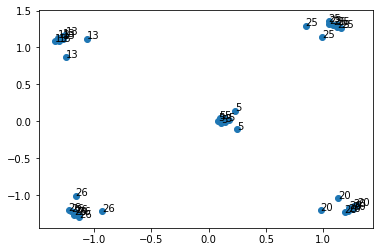

In [3372]:
fig, ax = plt.subplots()
ax.scatter(fit[:,0],fit[:,1])
for i, txt in enumerate(gm.predict(sr_rooms_random.M)):
    ax.annotate(txt, (fit[i,0],fit[i,1]))
plt.show()

And here are the cluster labels projected onto the drawing of the graph structure of the state space:

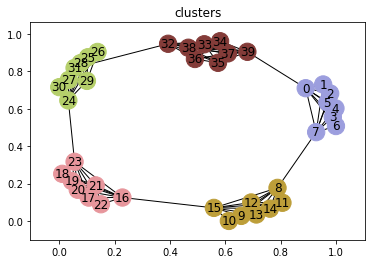

In [3374]:
# Plot cluster mapping on state space
cmap = plt.cm.tab20b
node_colors = [cmap(3*cluster_map[i]) for i in range(len(cluster_map))]
nx.draw_networkx(rooms,node_color=node_colors)
plt.title('clusters')
plt.show()

## State aggregation by clustering on successor representations

The above observations suggest that we might try to aggregate the state-space based on clusters found for successor representations of an agent on a random walk (Botvinick, Niv, Barto, 2008). I have chosen to incorporate this kind of representation learning by modifying the update equation of a simple TD-learning agent. First, I aggregate the state-space by performing Bayesian Gaussian mixture modeling to cluster states based on their successor representations on a random walk on the graph. Then the usual TD-learning algorithm is implemented with the following change to the update rule: the reward expectations for the current state is updated according to the usual TD-learning rule, but the other states in the current cluster are also updated according to a convex combination of their existing predictions and the newly updated current state's expectation.

Model: ("R" rather than "V" in code)
$$ V \in R^n $$
$$ f(s): \mathcal{S} \rightarrow \{ 0,1,...,k \} $$

where f(s) is a mapping that takes a state and maps it to a natural number corresponding to the cluster assigned to it. This mapping is found by Bayesian Gaussian mixture modeling.

Update equations in state $s^i$:
$$ V_{n+1}(s^i) = V_{n}(s^i) + \eta[R(s^i) + \gamma V(s_{n+1}) - V_{n}(s^i)] $$
$$ V_{n+1}(\{ s^k : f(s^k) = f(s^i) \}) = (1 - \alpha) V_{n}(s^k) + \alpha V_{n+1}(s^i) $$

where $\alpha$ is a hyperparameter that specifies the degree of mixing in the other states in the current cluster between their current expected reward values and the updated expected reward of the current state.

As a psychological model, this seems to make intuitive sense: people don't simply represent states in the original sensory input space, but form abstract representations of the state-space. This model assumes a kind of instrumental character to this abstraction, where states are grouped by the other states that are accessible from them. 

In the comparisons below, the clustering is performed prior to the training of the reward predictions. I did it this way just because I wanted to see if improvements could be made in general with this kind of approach - but of course it makes the actual comparisons unfair because this model has an opportunity to learn about the environment before training begins. One possible psychological justification of this would be to say that the clustering simply reflects the basic state-space represenations learned over time throughout development, but I mostly just wanted to see if it worked. I plan on implementing a class that learns the clusters as it goes (i.e. it starts with no knowledge of the environment like the others, and it performs clustering on each step, and uses the above cluster-based update rule as well). But in the end I plan on using a different algorithm for dimensionality reduction anyway (autoencoders or other kinds of neural networks), so I really just wanted to prove that this kind of thing would work in general.

Of course this model is likely inaccurate on the algorithmic and process levels, as it is unlikely that a clustering-algorithm-type process underlies the abstract representation-learning on the state-space. However, on the computational level, it seems to capture something interesting about how humans, and animals generally, might be representing their sensory state-spaces.

Another important thing to note here is that the use of successor representations to perform this clustering is relatively unimportant. What is important is that the states are clustered instrumentally - i.e. based on which other states are accessible from them. This could be captured by many different kinds of representation-learning algorithms. For example, a causality-based learning algorithm that could discover the causal structure of the environment would have access to similar representations of the state space.

The following code implements the above algorithm.  A couple notes:

- It is largely redundant with the earlier TD_rl and SR_rl classes, but it has a new method, 'aggregate', which learns the cluster-mapping based on the Bayesian Gaussian mixture modeling of the successor representations, and it uses the above update rule based on the learned mapping.

- I had to add an additional line to the code in the 'aggregate' method that ensures that the goal state is not clustered with any of the other states. This worked better because initially when the goal has not yet been found, the clustered learning will mean that the goal state is devalued along with all of the other states in the cluster (due to the -0.01 reward of every non-goal state). This might be cheating, but I think it is somewhat psychologically plausible because a real agent would not give up on a whole room simply because the first node in the room turned out not to be the goal.

- The class has an option to aggregate the state-space based on the SR's for a random walk ('onpolicy'=False) or for the true successor representations learned for an epsilon-greedy responding agent ('onpolicy'=True). The analyses below all use off-policy learning to cluster, mostly because I couldn't get the on-policy learning to work well enough (although I expect that with enough tuning of the hyperparameters, most importantly the temporal discounting factor and the learning rate for the successor representation learning, as well as alpha, I would be able to get it to work.

- Additionally, I built an option to use the uncertainty of the predicted rewards to determine alpha adaptively (alpha = 1/(number of times the state has been visited + 1)), but I couldn't get this to work. I was motivated by the thought that perhaps the mixing would be very beneficial in the beginning of training, where the cluster mapping would allow rapid generalization between states in the same cluster, but would be detrimental later in learning, where the agent should possibly be learning to differentiate states within a cluster based on the knowledge it has ammassed about the reward structure of the environment (e.g. the doors vs. nondoors of a room). Maybe a different equation for the uncertainty weighting would result in better learning?

In [3217]:
class cluster_SR_rl:
    def __init__(self,world,re=0.01,rg=0.9,sg=0.9,se=0.001,gg=1,epsilon = 0.1,T=3,Tg=0.99,l=0.95,softmax=False,nclusters=10,alpha=0.01,agg_onpolicy=False,uncertainty=0):
        self.world = world #learning environment
        #Hyperparameters
        self.rg = rg #temporal discounting parameter for reward learning
        self.re= re #learning rate for reward model
        self.sg = sg #temporal discounting parameter for SR learning
        self.se = se #learning rate for successor representation matrix
        self.epsilon = epsilon #epsilon-greedy parameter (probability of random action)
        self.gg = gg #epsilon-greedy discount factor
        self.T=T #initial temperature
        self.Tg=Tg #temperature discount factor for simulated annealing
        self.l = l #leaky integrator parameter
        self.softmax = softmax #Softmax for response rule
        self.nclusters = nclusters
        self.alpha = alpha #weight parameter for weighted average between current R value and cluster-average
        self.agg_onpolicy=agg_onpolicy
        self.uncertainty = uncertainty
        self.nnodes = world.number_of_nodes()
    
        #Model
        self.R = np.zeros(self.nnodes) #Reward model with dimension of original state space
        self.M = np.zeros([self.nnodes,self.nnodes])
        self.cluster_map = dict(zip(range(self.nnodes),range(self.nnodes))) #Mapping from original state space to new, lower dimensional state space
        self.visits = np.zeros(self.nnodes)
        
    def aggregate(self,goal,ntrials):
        if self.agg_onpolicy:
            #Train SR matrix on-policy
            sr_random = SR_rl(self.world,softmax=self.softmax,M_offpolicy=False,se=self.se,sg=self.sg,epsilon=self.epsilon,trial_structure=False)
            _ = sr_random.train(goal,ntrials)
            self.M = sr_random.M
        else:
            #Train SR matrix on random walk
            sr_random = SR_rl(self.world,softmax=self.softmax,M_offpolicy=False,se=self.se,sg=self.sg,epsilon=1,trial_structure=False)
            _ = sr_random.train(goal,ntrials)
            self.M = sr_random.M
        #Cluster states with Bayesian Gaussian Mixture model with Dirichlet prior
        gm = BayesianGaussianMixture(n_components=self.nclusters,covariance_type='spherical')
        gm = BayesianGaussianMixture.fit(gm,sr_random.M)
        self.cluster_map = np.array(gm.predict(sr_random.M))
        self.cluster_map[goal] = np.max(self.cluster_map) + 1
        self.nclusters = len(np.unique(self.cluster_map))
        
    def plot_clusters_MDS(self):
        #MDS on successor representations
        similarities = euclidean_distances(self.M)
        mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
        fit = mds.fit(similarities).embedding_
        # Plot MDS of successor representations with cluster labels
        fig, ax = plt.subplots()
        ax.scatter(fit[:,0],fit[:,1])
        for i, txt in enumerate(self.cluster_map):
            ax.annotate(txt, (fit[i,0],fit[i,1]))
        plt.show()
    
    def plot_clusters_world(self):
        # Plot cluster mapping on state space
        cmap = plt.cm.tab20b
        node_colors = [cmap(5*self.cluster_map[i]) for i in range(len(self.cluster_map))]
        nx.draw_networkx(self.world,node_color=node_colors)
        plt.title('clusters')
        plt.show()
    
    def train(self,goal,ntrials):
        state = np.random.choice(self.world.nodes()) #Random starting point
        count = 0 #Count for the number of steps it takes to reach the goal
        stepcounts = [] #Record number of steps taken on each trial
        temp = self.T
        eps = self.epsilon
        for i in range(ntrials):
            state = np.random.choice(self.world.nodes()) #Random starting point
            count = 0 #Start count over
            done = False
            while not done:
                done = (state == goal) or (count > 100)
                actions = self.world.neighbors(state) #Available next states
                greedy = np.random.rand() > eps #Decide if greedy action taken (softmax-greedy)
                if greedy:
                    if self.softmax:
                        next_state = np.random.choice(actions,p=np.exp(self.R[actions]/temp)/np.sum(np.exp(self.R[actions]/temp))) #softmax
                    else:
                        max_reward = np.max(self.R[actions]) #maximum reward of available actions
                        next_state = np.random.choice(np.array(actions)[(self.R[actions] == max_reward)]) #Choose randomly between actions with maximum reward
                else:
                    next_state = np.random.choice(actions)
                self.visits[next_state] = self.visits[next_state] + 1
                next_actions = self.world.neighbors(next_state)
                reward = 1 if (next_state == goal) or (state==goal) else -0.01 #reward for the next state
                best_action = next_actions[np.argmax(self.R[next_actions])]
                #Update R
                self.R[state] = self.R[state] + self.re*(reward + self.rg*self.R[best_action] - self.R[state])
                others_in_cluster = [self.cluster_map[k] == self.cluster_map[state] for k in range(self.nnodes)]
                alpha = np.ones(self.nnodes)
                if self.uncertainty:
                    alpha = (1/(self.visits[others_in_cluster]+1)) if np.min(alpha) > 0.0001 else alpha
                    self.R[others_in_cluster] = (1-self.alpha)*self.R[others_in_cluster] + alpha*self.R[state]
                else:
                    self.R[others_in_cluster] = (1-self.alpha)*self.R[others_in_cluster] + self.alpha*self.R[state]
                #Update state
                state = next_state
                count += 1
                eps = eps*self.gg
            stepcounts.append(count)
            if temp > 0.1:
                temp = temp*self.Tg #Update temperature for simulated annealing
        return stepcounts
    
    def test(self,goal,ntest):
        count = 0 #Count for the number of steps it takes to reach the goal
        extrasteps = [] #Record number of steps taken on each trial
        for i in range(ntest):
            state = np.random.choice(self.world.nodes()) #Random starting point
            minsteps = nx.shortest_path_length(self.world,source=state,target=goal) #Compute shortest possible path
            count = 0 #Start count over
            while (state != goal) and (count < 100):
                actions = self.world.neighbors(state) #Available next states
                max_reward = np.max(self.R[actions]) #maximum reward of available actions
                state = np.random.choice(np.array(actions)[(self.R[actions] == max_reward)]) #Choose randomly between actions with maximum reward
                count += 1
            extrasteps.append(count-minsteps)
        return extrasteps

## Comparison: TD vs. SR vs. Cluster

To test the models, I made a few qualitatively different environments, shown below (they are kind of ugly to look at because I wanted to make them have relatively large state spaces so that the differences between environments and models would be larger). I set up a loop for each model for each environment that trained for 5 trials (each of which ends when the agent finds the goal state), and then tested for 50 trials, keeping track of the 'extrasteps', i.e. the difference between the number of steps taken and the minimal number of steps to the goal). No learning occurred during testing. I had so many testing trials because I wanted to reduce noise in the estimation of performance in general throughout training.

In [3494]:
# Setup
goal = 7
ntrials = 100
ntest = 50
agg_trials = 1000 # For cluster_SR

### Big rooms
- 5 big rooms with 50 states each, forming a circle

In [3537]:
nrooms = 5
roomsize = 50
bigrooms = nx.Graph()
for r in range(nrooms):
    Gnodes = range(r*roomsize,r*roomsize + roomsize)
    Gedges = itertools.combinations(Gnodes,2)
    G = nx.Graph()
    G.add_nodes_from(Gnodes)
    G.add_edges_from(Gedges)
    bigrooms = nx.compose(bigrooms,G)
    if r > 0:
        bigrooms.add_edge(r*roomsize-1,r*roomsize)
bigrooms.add_edge(nrooms*roomsize-1,0)

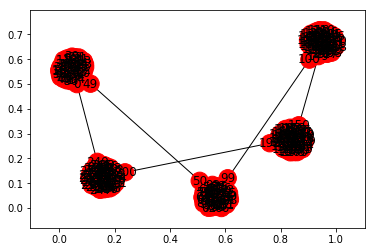

In [3538]:
node_colors = ['y' if i == goal else 'r' for i in range(bigrooms.number_of_nodes())]
nx.draw_networkx(bigrooms,node_color=node_colors)
plt.show()

In [3539]:
# TD on bigrooms
td_bigrooms = TD_rl(bigrooms,rg=0.9,re=0.01,epsilon=0.1,softmax=False)
td_bigrooms_train = []
td_bigrooms_test = []
for i in range(ntrials):
    td_bigrooms_train = td_bigrooms_train + td_bigrooms.train(goal,5)
    td_bigrooms_test = td_bigrooms_test + [np.mean(td_bigrooms.test(goal,ntest))]

In [3540]:
# SR on bigrooms
sr_bigrooms = SR_rl(bigrooms,rg=0.9,re=0.01,epsilon=0.1,softmax=False,sg=0.9,se=0.05,l=0.8,M_offpolicy=False)
sr_bigrooms_train = []
sr_bigrooms_test = []
for i in range(ntrials):
    sr_bigrooms_train = sr_bigrooms_train + sr_bigrooms.train(goal,5)
    sr_bigrooms_test = sr_bigrooms_test + [np.mean(sr_bigrooms.test(goal,ntest))]

In [3541]:
# cluster_SR on bigrooms
cluster_SR_bigrooms = cluster_SR_rl(bigrooms,rg=0.9,re=0.01,epsilon=0.1,softmax=False,nclusters=20,alpha=0.15,agg_onpolicy=False,uncertainty=0)
cluster_SR_bigrooms.aggregate(goal=goal,ntrials=agg_trials)
cluster_SR_bigrooms_train = []
cluster_SR_bigrooms_test = []
for i in range(ntrials):
    cluster_SR_bigrooms_train = cluster_SR_bigrooms_train + cluster_SR_bigrooms.train(goal,5)
    cluster_SR_bigrooms_test = cluster_SR_bigrooms_test + [np.mean(cluster_SR_bigrooms.test(goal,ntest))]

Map of the clusters learned:

In [3542]:
cluster_SR_bigrooms.nclusters

6

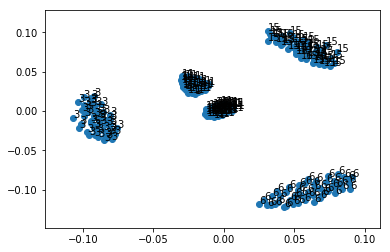

In [3543]:
cluster_SR_bigrooms.plot_clusters_MDS()

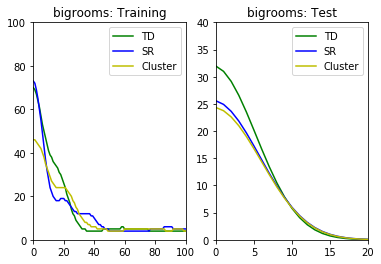

In [3544]:
# Comparison on bigrooms training
plt.subplot(121)
plt.plot(ndimage.gaussian_filter1d(td_bigrooms_train,5),'-g',ndimage.gaussian_filter1d(sr_bigrooms_train,5),'-b',ndimage.gaussian_filter1d(cluster_SR_bigrooms_train,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('bigrooms: Training')
plt.axis([0,100,0,100])
# Comparison on bigrooms test
plt.subplot(122)
plt.plot(ndimage.gaussian_filter1d(td_bigrooms_test,5),'-g',ndimage.gaussian_filter1d(sr_bigrooms_test,5),'-b',ndimage.gaussian_filter1d(cluster_SR_bigrooms_test,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('bigrooms: Test')
plt.axis([0,20,0,40])
plt.show()

### Hub
- Big rooms with a single node in the middle connecting all of the rooms

In [3503]:
nrooms = 5
roomsize = 50
hub = nx.Graph()
for r in range(nrooms):
    Gnodes = range(r*roomsize,r*roomsize + roomsize)
    Gedges = itertools.combinations(Gnodes,2)
    G = nx.Graph()
    G.add_nodes_from(Gnodes)
    G.add_edges_from(Gedges)
    hub = nx.compose(hub,G)
hub_node = nrooms*roomsize
hub.add_node(hub_node)
hub_edges = [(hub_node,i*roomsize) for i in range(nrooms)]
hub.add_edges_from(hub_edges)

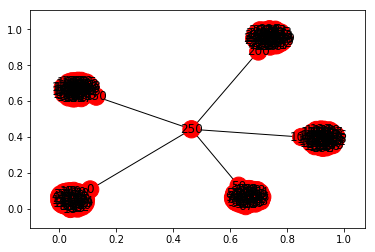

In [3504]:
node_colors = ['y' if i == goal else 'r' for i in range(hub.number_of_nodes())]
nx.draw_networkx(hub,node_color=node_colors)
plt.show()

In [3505]:
# TD on hub
td_hub = TD_rl(hub,rg=0.9,re=0.01,epsilon=0.1,softmax=False)
td_hub_train = []
td_hub_test = []
for i in range(ntrials):
    td_hub_train = td_hub_train + td_hub.train(goal,5)
    td_hub_test = td_hub_test + [np.mean(td_hub.test(goal,ntest))]

In [3506]:
# SR on hub
sr_hub = SR_rl(hub,rg=0.9,re=0.01,epsilon=0.1,softmax=False,sg=0.9,se=0.05,l=0.8,M_offpolicy=False)
sr_hub_train = []
sr_hub_test = []
for i in range(ntrials):
    sr_hub_train = sr_hub_train + sr_hub.train(goal,5)
    sr_hub_test = sr_hub_test + [np.mean(sr_hub.test(goal,ntest))]

In [3507]:
# cluster_SR on hub
cluster_SR_hub = cluster_SR_rl(hub,rg=0.9,re=0.01,epsilon=0.1,softmax=False,nclusters=20,alpha=0.1)
cluster_SR_hub.aggregate(goal=goal,ntrials=agg_trials)
cluster_SR_hub_train = []
cluster_SR_hub_test = []
for i in range(ntrials):
    cluster_SR_hub_train = cluster_SR_hub_train + cluster_SR_hub.train(goal,5)
    cluster_SR_hub_test = cluster_SR_hub_test + [np.mean(cluster_SR_hub.test(goal,ntest))]

In [3508]:
cluster_SR_hub.nclusters

6

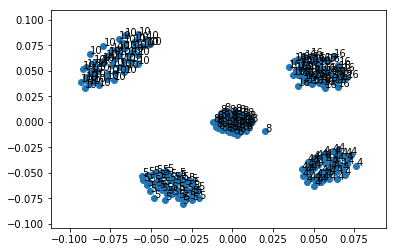

In [3509]:
cluster_SR_hub.plot_clusters_MDS()

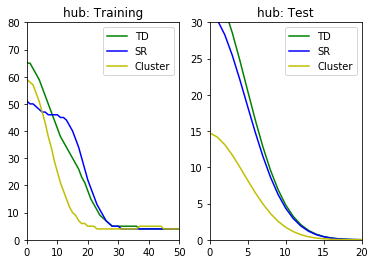

In [3510]:
# Comparison on hub training
plt.subplot(121)
plt.plot(ndimage.gaussian_filter1d(td_hub_train,5),'-g',ndimage.gaussian_filter1d(sr_hub_train,5),'-b',ndimage.gaussian_filter1d(cluster_SR_hub_train,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('hub: Training')
plt.axis([0,50,0,80])
# Comparison on hub test
plt.subplot(122)
plt.plot(ndimage.gaussian_filter1d(td_hub_test,5),'-g',ndimage.gaussian_filter1d(sr_hub_test,5),'-b',ndimage.gaussian_filter1d(cluster_SR_hub_test,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('hub: Test')
plt.axis([0,20,0,30])
plt.show()

### Lollipop flower
- 5 big rooms connected to a single node in the middle, but with longer 'tunnels' connecting them to the central node (hard to get this structure to come out in the drawing of the graph)

In [3511]:
lollipops = 5
stemsize = 3
popsize = 50
lflow = nx.Graph()
for i in range(lollipops):
    G = nx.lollipop_graph(popsize,stemsize)
    label_map = dict(zip(range(stemsize+popsize),range(i*(stemsize+popsize),(i+1)*(stemsize+popsize))))
    G = nx.relabel_nodes(G,label_map)
    lflow = nx.compose(lflow,G)
    lflow.add_edge(np.max(G.nodes()),stemsize+popsize - 1)

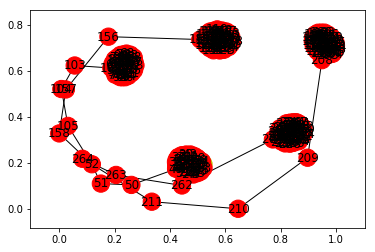

In [3512]:
node_colors = ['y' if i == goal else 'r' for i in range(lflow.number_of_nodes())]
nx.draw_networkx(lflow,node_color=node_colors)
plt.show()

In [3513]:
ntrials = 500
ntest = 10

In [3514]:
# TD on lflow
td_lflow = TD_rl(lflow,rg=0.9,re=0.01,epsilon=0.1,softmax=False)
td_lflow_train = []
td_lflow_test = []
for i in range(ntrials):
    td_lflow_train = td_lflow_train + td_lflow.train(goal,5)
    td_lflow_test = td_lflow_test + [np.mean(td_lflow.test(goal,ntest))]

In [3515]:
# SR on lflow
sr_lflow = SR_rl(lflow,rg=0.9,re=0.01,epsilon=0.1,softmax=False,sg=0.9,se=0.05,l=0.8,M_offpolicy=False)
sr_lflow_train = []
sr_lflow_test = []
for i in range(ntrials):
    sr_lflow_train = sr_lflow_train + sr_lflow.train(goal,5)
    sr_lflow_test = sr_lflow_test + [np.mean(sr_lflow.test(goal,ntest))]

In [3516]:
# cluster_SR on lflow
cluster_SR_lflow = cluster_SR_rl(lflow,rg=0.9,re=0.01,epsilon=0.1,softmax=False,nclusters=265,alpha=0.001)
cluster_SR_lflow.aggregate(goal=goal,ntrials=agg_trials)
cluster_SR_lflow_train = []
cluster_SR_lflow_test = []
for i in range(ntrials):
    cluster_SR_lflow_train = cluster_SR_lflow_train + cluster_SR_lflow.train(goal,5)
    cluster_SR_lflow_test = cluster_SR_lflow_test + [np.mean(cluster_SR_lflow.test(goal,ntest))]

In [3517]:
cluster_SR_lflow.nclusters

5

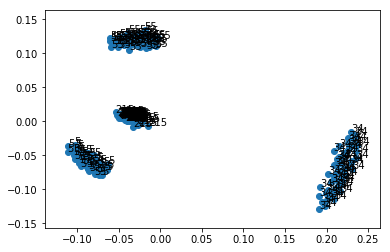

In [3518]:
cluster_SR_lflow.plot_clusters_MDS()

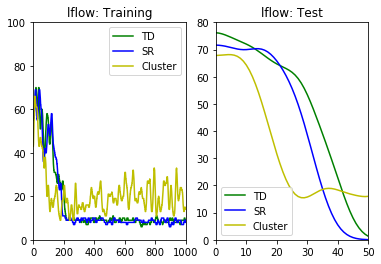

In [3519]:
# Comparison on lflow training
plt.subplot(121)
plt.plot(ndimage.gaussian_filter1d(td_lflow_train,5),'-g',ndimage.gaussian_filter1d(sr_lflow_train,5),'-b',ndimage.gaussian_filter1d(cluster_SR_lflow_train,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('lflow: Training')
plt.axis([0,1000,0,100])
# Comparison on lflow test
plt.subplot(122)
plt.plot(ndimage.gaussian_filter1d(td_lflow_test,5),'-g',ndimage.gaussian_filter1d(sr_lflow_test,5),'-b',ndimage.gaussian_filter1d(cluster_SR_lflow_test,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('lflow: Test')
plt.axis([0,50,0,80])
plt.show()

### Tree
- Balanced tree with 3 branches per parent node, and 4 levels (hard to visualize - the goal 7 lies somewhere on the second level

In [3520]:
tree = nx.balanced_tree(3,4)

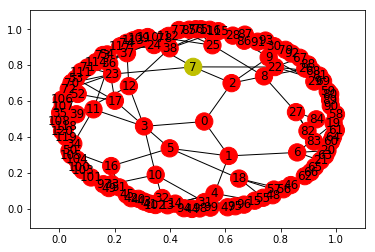

In [3521]:
node_colors = ['y' if i == goal else 'r' for i in range(tree.number_of_nodes())]
nx.draw_networkx(tree,node_color=node_colors)
plt.show()

In [3522]:
# TD on tree
td_tree = TD_rl(tree,rg=0.9,re=0.01,epsilon=0.1,softmax=False)
td_tree_train = []
td_tree_test = []
for i in range(ntrials):
    td_tree_train = td_tree_train + td_tree.train(goal,5)
    td_tree_test = td_tree_test + [np.mean(td_tree.test(goal,ntest))]

In [3523]:
# SR on tree
sr_tree = SR_rl(tree,rg=0.9,re=0.01,epsilon=0.3,softmax=False,sg=0.9,se=0.05,l=0.8,M_offpolicy=False)
sr_tree_train = []
sr_tree_test = []
for i in range(ntrials):
    sr_tree_train = sr_tree_train + sr_tree.train(goal,5)
    sr_tree_test = sr_tree_test + [np.mean(sr_tree.test(goal,ntest))]

In [3524]:
# cluster_SR on tree
cluster_SR_tree = cluster_SR_rl(tree,rg=0.9,re=0.01,epsilon=0.1,softmax=False,nclusters=100,alpha=0.11)
cluster_SR_tree.aggregate(goal=goal,ntrials=agg_trials)
cluster_SR_tree_train = []
cluster_SR_tree_test = []
for i in range(ntrials):
    cluster_SR_tree_train = cluster_SR_tree_train + cluster_SR_tree.train(goal,5)
    cluster_SR_tree_test = cluster_SR_tree_test + [np.mean(cluster_SR_tree.test(goal,ntest))]

In [3525]:
cluster_SR_tree.nclusters

67

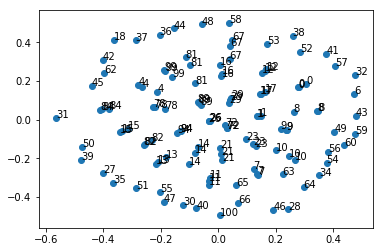

In [3526]:
cluster_SR_tree.plot_clusters_MDS()

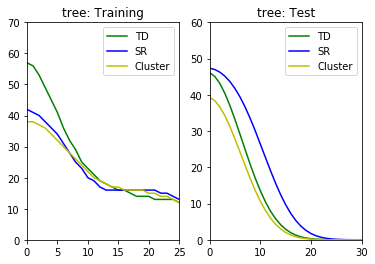

In [3527]:
# Comparison on tree training
plt.subplot(121)
plt.plot(ndimage.gaussian_filter1d(td_tree_train,5),'-g',ndimage.gaussian_filter1d(sr_tree_train,5),'-b',ndimage.gaussian_filter1d(cluster_SR_tree_train,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('tree: Training')
plt.axis([0,25,0,70])
# Comparison on tree test
plt.subplot(122)
plt.plot(ndimage.gaussian_filter1d(td_tree_test,5),'-g',ndimage.gaussian_filter1d(sr_tree_test,5),'-b',ndimage.gaussian_filter1d(cluster_SR_tree_test,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('tree: Test')
plt.axis([0,30,0,60])
plt.show()

### Binomial random graph
- 100 nodes with Pr[edge] = 0.07

In [3528]:
binomial = nx.binomial_graph(100,0.07)

In [3529]:
nx.is_connected(binomial)

True

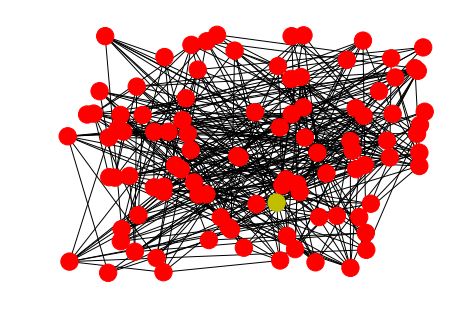

In [3553]:
node_colors = ['y' if i == goal else 'r' for i in range(binomial.number_of_nodes())]
nx.draw_random(binomial,node_color=node_colors)
plt.show()

In [3531]:
# TD on binomial
td_binomial = TD_rl(binomial,rg=0.9,re=0.01,epsilon=0.1,softmax=False)
td_binomial_train = []
td_binomial_test = []
for i in range(ntrials):
    td_binomial_train = td_binomial_train + td_binomial.train(goal,5)
    td_binomial_test = td_binomial_test + [np.mean(td_binomial.test(goal,ntest))]

In [3532]:
# SR on binomial
sr_binomial = SR_rl(binomial,rg=0.9,re=0.01,epsilon=0.3,softmax=False,sg=0.9,se=0.05,l=0.8,M_offpolicy=False)
sr_binomial_train = []
sr_binomial_test = []
for i in range(ntrials):
    sr_binomial_train = sr_binomial_train + sr_binomial.train(goal,5)
    sr_binomial_test = sr_binomial_test + [np.mean(sr_binomial.test(goal,ntest))]

In [3533]:
# cluster_SR on binomial
cluster_SR_binomial = cluster_SR_rl(binomial,rg=0.9,re=0.01,epsilon=0.1,softmax=False,nclusters=80,alpha=0.1)
cluster_SR_binomial.aggregate(goal=goal,ntrials=agg_trials)
cluster_SR_binomial_train = []
cluster_SR_binomial_test = []
for i in range(ntrials):
    cluster_SR_binomial_train = cluster_SR_binomial_train + cluster_SR_binomial.train(goal,5)
    cluster_SR_binomial_test = cluster_SR_binomial_test + [np.mean(cluster_SR_binomial.test(goal,ntest))]

In [3534]:
cluster_SR_binomial.nclusters

80

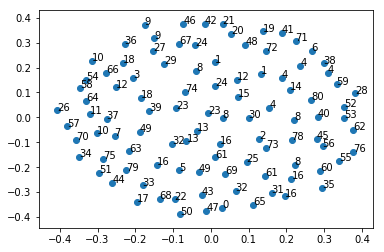

In [3535]:
cluster_SR_binomial.plot_clusters_MDS()

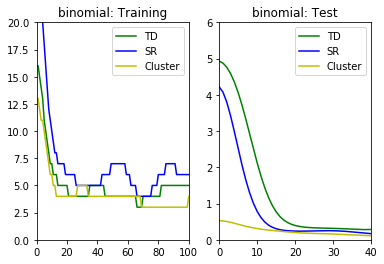

In [3536]:
# Comparison on binomial training
plt.subplot(121)
plt.plot(ndimage.gaussian_filter1d(td_binomial_train,5),'-g',ndimage.gaussian_filter1d(sr_binomial_train,5),'-b',ndimage.gaussian_filter1d(cluster_SR_binomial_train,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('binomial: Training')
plt.axis([0,100,0,20])
# Comparison on binomial test
plt.subplot(122)
plt.plot(ndimage.gaussian_filter1d(td_binomial_test,5),'-g',ndimage.gaussian_filter1d(sr_binomial_test,5),'-b',ndimage.gaussian_filter1d(cluster_SR_binomial_test,5),'-y')
plt.legend(['TD','SR','Cluster'])
plt.title('binomial: Test')
plt.axis([0,40,0,6])
plt.show()

## General discussion

### Results

The results showed that successor representation learning had better performance on each environment (although occassionally there were rare runs in which the TD learning actually outperformed the SR learning on the tree environment). On most of these environments the clustering on successor representations showed better performance than either of the other two algorithms. However, on the "lollipop-flower" environment, the clustering diminished performace. I think that this was due to the "tunnels" between the rooms and the central hub. When all of the nodes on the "tunnels" were clustered together (as they usually were) learning was made more difficult because the agent would be more likely to go the wrong direction once it was half-way through the tunnel. My future explorations of these kinds of algorithms will definitely have to include environments where "tunnel-like" structures are present, as these seem to be ubiquitous in everyday life, e.g. in tasks where a particular sequence of actions must be executed in a specific order to achieve a goal. 

### Future directions

Below are some of the directions I hope to take this project (for my first-year project). I plan on working a lot on the modeling and theory, and then running some behavioral and EEG experiments to try to differentiate qualitatively different predictions from the most psychologically plausible models.

Some directions I hope to go with the modeling:
- Exploring other ways of learning causal structure (i.e. what states are possible from what other states) that would accomplish the same instrumental representation learning made possible by the successor representations.
- Exploring successor representations on the action space rather than the state space
- Neural network implementations:
    - Feedforward network that parameterizes the SR-matrix
    - Predictive network with lower-dimensional hidden layer for dimensionality reduction on state space, where the reward function is learned on that lower-dimensional space
    - Explore the possibility that a recurrent network could learn successor-like representations
- Model-based RL: saltatory tree-search
    - The Botvinick (2008) paper discusses the possibility of using "temporal abstraction" techniques similar to successor representations for doing "saltatory tree-search" in the model-based setting, where the agent can look ahead in the future to plan without needing to simulate each step of a low-level action sequence. This would greatly reduce the exponential complexity of the tree-search, and I think this is a very intuitive psychological model: it seems introspectively that we do indeed plan in a temporally-abstract space where we don't know many of the low-level action sequences that we will end up performing to execute those plans.
- Reward revaluation, changes to environmental contingencies - transfer learning
    - The Mommenejad et al. (2016) paper emphasizes the qualitatively different predictions made by the models for environemnts in which the reward or transition contingencies are changed. This kind of paradigm will be especially informative for distinguishing different models of saltatory tree-search, which should be able to handle reward revaluation very well.

### References
- Botvinick, M.M., Niv, Y., Barto, A.C. (2008) Hierarchically organized behavior and its neural foundations: a reinforcement-learning perspective. Cognition
- Dayan, P. (1993). Improving generalization for temporal difference learning: The successor representation. Neural Computation, 5, 613–624.
- Gershman, S. J., Moore, C. D., Todd, M. T., Norman, K. A., & Sederberg, P. B. (2012). The successor representation and temporal context. Neural Computation, 24(6), 1553-1568.
- Momennejad, Russek, Cheong, Botvinick, Daw, Gershman (2016) The successor representation in human reinforcement learning. bioRxiv doi: http://dx.doi.org/10.1101/083824.
- White, L. (1995). Temporal difference learning: Eligibility traces and the successor repre- sentation for actions. Unpublished master’s thesis, University of Toronto.

